# (01) análisis exploratorio: datos faltantes
### - dataset clasificación de ingresos 
entorno:  eda (anaconda)

Dado que se ha encontrado una cantidad significativa de datos faltantes implícitos en el dataset de estudio. *En este notebook nos centraremos en hace un analizar la influencia que tienen los datos faltantes en los datos completos.* 
* Los nulos estaban escondidos bajo la categoría "**unknown**"
#### ℹ️ Aclaraciones
* se imlementarán dos módulos que extienden las funcionalidades de pandas. Dicha extensión de pandas es la siguiente:
`@pd.api.extensions.register_dataframe_accessor('missing')` se usará $\rightarrow$ *missing*

    * **path**: *./scripts/utils_missing_extension.py* & *./scripts/utils_missing_extension_plots.py*

* Las funciones auxiliares usadas en este notebook están en: 

    * **path**: *./modules/imputation_module*

#### Objetivos:
* Reconocer qué tipo de datos faltantes hay en el dataset
* Indagar sobra su influencia en el dataset
* tomar una desición respecto a qué hacer con ellos *(imputarlos, eliminarlos)*

### importación  de librerías, módulos y dataset

In [1]:
# libraries

#import janitor
import missingno
import math
import matplotlib.pyplot as plt
import numpy   as np
import pandas  as pd
import seaborn as sns
#import statsmodels
#import statsmodels.api as sm
#import statsmodels.formula.api as smf

from scipy.stats             import  chi2_contingency
#from sklearn.impute          import  KNNImputer, SimpleImputer
#from sklearn.preprocessing   import  OneHotEncoder # codificar variables categóricas
#from sklearn.tree            import  DecisionTreeClassifier
from typing import List

In [2]:
# own modules
from import_modules import import_to_nb

# plotting & eda functions
import_to_nb(directory= 'scripts', show_content= False)

# lists, dicts & auxiliar functions (for this notebook)
import_to_nb(directory= 'modules', show_content= False) 

#-# directory: scripts
from load_data import Loader
from utils     import Utils
from utils_missing_extension_plots import MissingPlotMethods
from utils_missing_extension       import MissingMethods
from utils_initial_exploration     import InitialExploration
from utils_categorical_plots       import CategoricalPlots
from utils_classif_models_plots    import ClassifModelsPlots
from utils_probability_funcs       import ProbabilityFuncs

#-# directory: modules
from module_imputation             import Imputation_module # imputation methods 

In [3]:
load          = Loader()
utils         = Utils()
initial_exp   = InitialExploration()
cat_plots     = CategoricalPlots()
classif_plots = ClassifModelsPlots()
prob          = ProbabilityFuncs()
imputation    = Imputation_module()

In [4]:
# load appereance
utils.load_appereance()

In [5]:
df_clean = load.load_data(file_name= 'adult_clean', dir= 'clean')
df_clean[:3]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,genre,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,state_gov,77516,bachelors,13,never_married,adm_clerical,not_in_family,white,Male,2174,0,40,USA,no
1,50,self_emp_not_inc,83311,bachelors,13,married_civ_spouse,exec_managerial,husband,white,Male,0,0,13,USA,no
2,38,Private,215646,hs_grad,9,divorced,handlers_cleaners,not_in_family,white,Male,0,0,40,USA,no


### comienzo del análisis

## (1.1) valores *"other"*

<div class="alert alert-info">
    <b style="font-size: 1.5em;">🛑 antes de comenzar el análisis de datos faltantes </b>
    <p> Se ha detectado un potencial problema que es importante revisar:</p>
    <p> - Hay valores con prefijo "<b>other</b>" dentro de las columnas: <i>ethnicity, occupation, relationship</i></p>  
</div>
<div class="alert alert-info">
    <b style="font-size: 1.5em;">🔍 valores <i>unknown</i> vs <i>other</i></b>
    <br>
    <b>unknown</b>: Después de un análisis descriptivo, <b>no</b> encontramos evidencia suficiente como para hacer un tratemiento especial con ellos. Por tal motivo los consideraremos <i>valores faltantes</i>. Su aparición podría deberse a alguna de las siguientes:
    <ol>
        <li>El encuestado <b>no ha respondido</b> a la pregunta (el valor en cuestión no existe)</li>
        <li>hubo <b>errores a la hora de captar el valor</b> en cuestión.</li>
        <li> <b>La pregunta está mal implementada</b>, tal que desmotiva al encuestado a contestar <i>(dado que la encuesta ya está hechoa, este facotr no podríamos controlarlo)</i></li>
    </ol>
    <p>Será importante detectar  de qué tipo son, lo que ayudará a decidir qué hacer con ellos <i>(imputarlos, eliminarlos)</i></p>
    <p><b>other</b>: NO son valores "unknown" como tal. Ya que <b>representa una categoría válida</b> donde la respuesta del individuo no encaja en las categorías predefinidas.</p>
    <ul>
        <li><b>other</b> se interpretaría como una <i>respuesta poco común</i>, partiendo de la premisa de que las categorías representadas son las que más comunmente suelen contestar los encuestados </li>
        <li><i>(hipótesis que se confirma al considerar que ninguno de los valores con prefijo other está entre las respuestas más elegidas)</i></li>
    </ul>
    <p>A partir de esto, se ha decidido <b>NO CONSIDERAR</b> a los valores con prefijo <i>other</i> como un valor faltante. Por las siguientes razones:</p>
    <ul>
        <li>Aportan información sobre segmentos de la población que <b>no encajan dentro de las categorías más comunes</b></li>
        <li>ES una categoría legítima y válida dentro del dataset, dado que <b>contiene una respuesta real</b> proporcionada por el encuestado</li>
        <li>No se considera que este valor vaya a introducir sesgo en el modelo</li>
    </ul>
    <p>No se tocará ninguna de las columnas con valores con prefijo <i>other</i>. Para lograr <b>consistencia</b> en los resultados del futuro entrenamiento del modelo.</p>
</div>

In [6]:
# "other" prefix values count
other_vals = ['other', 'other_service', 'other_relative']
for i in other_vals:
    result = df_clean[df_clean == i].count().sum()
    print(f'value: "{i.upper()}" appear {result} times')
    print(f'total rows: {df_clean.shape[0]}')

value: "OTHER" appear 406 times
total rows: 48813
value: "OTHER_SERVICE" appear 4919 times
total rows: 48813
value: "OTHER_RELATIVE" appear 1506 times
total rows: 48813


## (1.2) análisis inicial de valores nulos

#### Null: count & proportion

In [7]:
#total de filas con unknown y sin unknown
data_unk = df_clean[df_clean.isin(['unknown']).any(axis= 1)]#
data_unk_cols = data_unk.isin(['unknown']).sum().sum()

print(f'  total rows:.................................{df_clean.shape[0]}\n',
      f' rows with at least 1 unknown:...............{data_unk.shape[0]}\n',
      f' rows without unknowns:......................{df_clean.shape[0] - data_unk.shape[0]}\n',
      f' proportion of rows with at least 1 unknown: {(data_unk.shape[0] / df_clean.shape[0]) *100}\n',
      f' proportion of rows without unknowns:........{100 - ((data_unk.shape[0] / df_clean.shape[0])*100)}')

"""Calculate the proportion of unknown values in a column"""
def unk_prop(df: pd.DataFrame, cols: List[str]):
        print(f'\n*-* DF with unknown proportion values *-*')
        unk_prop = {}
        df_unk_prop = pd.DataFrame()
        for col in cols:
                data_unk_col = df[col].isin(['unknown']).sum()
                unk_prop[col] = (data_unk_col / df.shape[0]) *100
                df_unk_prop = pd.DataFrame(unk_prop, index= ['proportion'])
        return df_unk_prop
  
unk_prop(df= df_clean, cols= ['occupation', 'workclass', 'native_country'])

  total rows:.................................48813
  rows with at least 1 unknown:...............3619
  rows without unknowns:......................45194
  proportion of rows with at least 1 unknown: 7.414008563292565
  proportion of rows without unknowns:........92.58599143670743

*-* DF with unknown proportion values *-*


,occupation,workclass,native_country
proportion,5.754615,5.734128,1.753631


In [8]:
#replace: "unknown" -> null
#df_clean = df_clean.replace('unknown', np.nan)
#load.save_dataframe(df= df_clean, file_name= 'adult_with_nan', dir= 'clean')

df_nan = load.load_data(file_name= 'adult_with_nan', dir= 'clean')

miss_vals     = df_nan.missing.number_missing()
complete_vals = df_nan.missing.number_complete()
total = miss_vals + complete_vals

print(f'- total values -\nmissing:  {miss_vals}\ncomplete: {complete_vals}\ntotal:    {total}')

- total values -
missing:  6464
complete: 725731
total:    732195


A continuación se hará un cálculo de nulos por columna, estableciendo (de manera arbitraria) una tolerancia máxima del $9$% de valores nulos
* Por lo que cualquier columna que sobrepase tal cantidad de nulos, entrará en la categoría de *too much nulls*

In [9]:
# null tolerance -> 9%
df_nan.missing.count_nulls_per_col(acceptable_nulls= 0.09, summary= True)

ROWS number: 48813, COLUMNS number: 15

- Columns without nulls: 
 ['age', 'fnlwgt', 'education', 'education_num', 'marital_status', 'relationship', 'ethnicity', 'genre', 'capital_gain', 'capital_loss', 'hours_per_week', 'income']

- Acceptable columns (nulls less than 9%):
 ['workclass', 'occupation', 'native_country']

- Too much nulls:
 []

- Null value tolerance: 9.0%


*Ninguna de las columnas sobrepasa la tolerancia máxima.*

* Lo cual es **positivo** y establece un punto a favor a la eliminación de las filas con valores nulos *(en caso de decidir esta opción)*

In [10]:
# nulls by column
initial_exp.initial_exploration(df= df_nan).sort_values(by= 'null_count', ascending= False)[:3]

,type,not_null_count,null_count,null_percent
occupation,object,46004,2809,5.755
workclass,object,46014,2799,5.734
native_country,object,47957,856,1.754


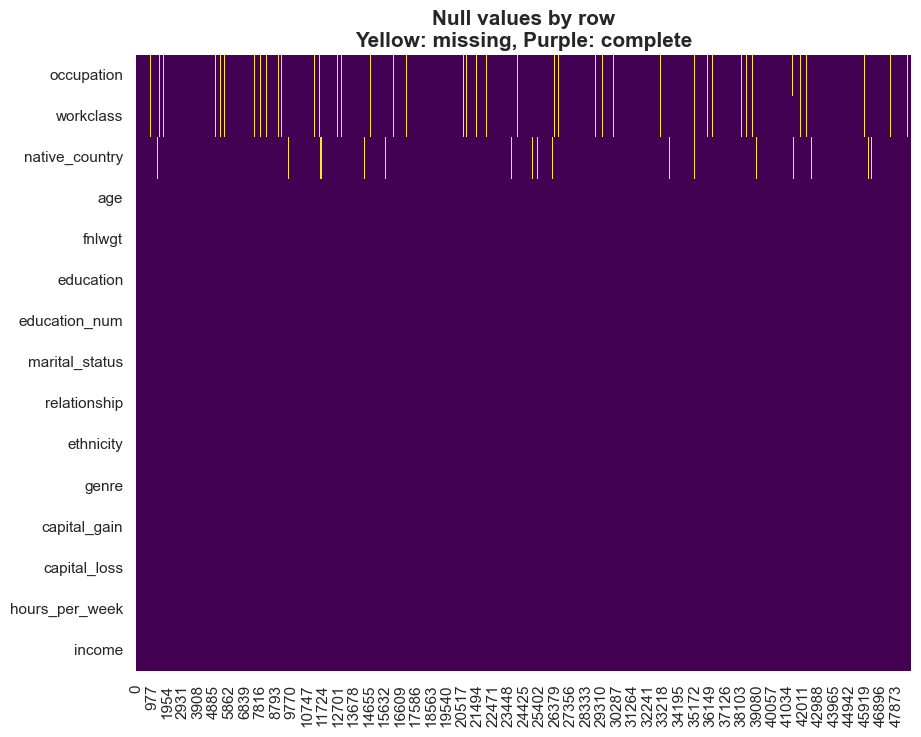

In [11]:
# heatmap: missing values by row
df_nan = df_nan.missing.sort_variables_by_missingness()
initial_exp.plot_nulls_heatmap(df= df_nan)

In [12]:
case_summary = (df_nan.missing.missing_case_summary()
                .sort_values(by= 'percent_missing', ascending= False))

case_summary_1 = case_summary[case_summary['n_missing'] > 0] #rows with al least 1 null
case_summary_2 = case_summary[case_summary['n_missing'] > 1] #rows with 2 or more nulls
print(f' rows with 2 or more nulls: {case_summary_2.shape[0]}\n',
      f'total rows with nulls:     {case_summary_1["n_missing"].shape[0]}')

prop_nulls = round(((case_summary_2.shape[0] / case_summary_1.shape[0]) *100), 2)
prop_nulls

 rows with 2 or more nulls: 2799
 total rows with nulls:     3619


77.34

Se observan indicios de apariciones conjuntas entre dos columnas (*occupation & workclass*).

La mayoría de las filas que contienen almenos 2 nulos. Estas conforman un $77.3$% del total de las filas con datos faltantes.
Lo que afirma el agrupamientos de nulos 

## (1.3) Datos faltantes presentes en filas donde `income` = *yes* vs *no*

In [13]:
#null count by rows, given "income"= yes & "income"= no
income_yes = df_nan[df_nan['income'] == 'yes']
income_no  = df_nan[df_nan['income'] == 'no']

print(f' - TOTAL values (not rows)-\n *-Missing values-*\n yes: {income_yes.missing.number_missing()}\n',
      f'no: {income_no.missing.number_missing()}\n{"-*"*10}\n',
      f'*-complete values-*\n yes: {income_yes.missing.number_complete()}\n',
      f' no: {income_no.missing.number_complete()}')

def total_proportion_cal(df: pd.DataFrame, col= 'income'):
    prop = (round((df.missing.number_missing()/
                   (df.missing.number_missing() + df.missing.number_complete())
                   *100), 3))  
    return prop

print(f'\nMISSING proportion values\n (row income = yes)-> {total_proportion_cal(df= income_yes)}%\n',
      f'(row income = no) -> {total_proportion_cal(df= income_no)}%')

 - TOTAL values (not rows)-
 *-Missing values-*
 yes: 750
 no: 5714
-*-*-*-*-*-*-*-*-*-*
 *-complete values-*
 yes: 174525
  no: 551206

MISSING proportion values
 (row income = yes)-> 0.428%
 (row income = no) -> 1.026%


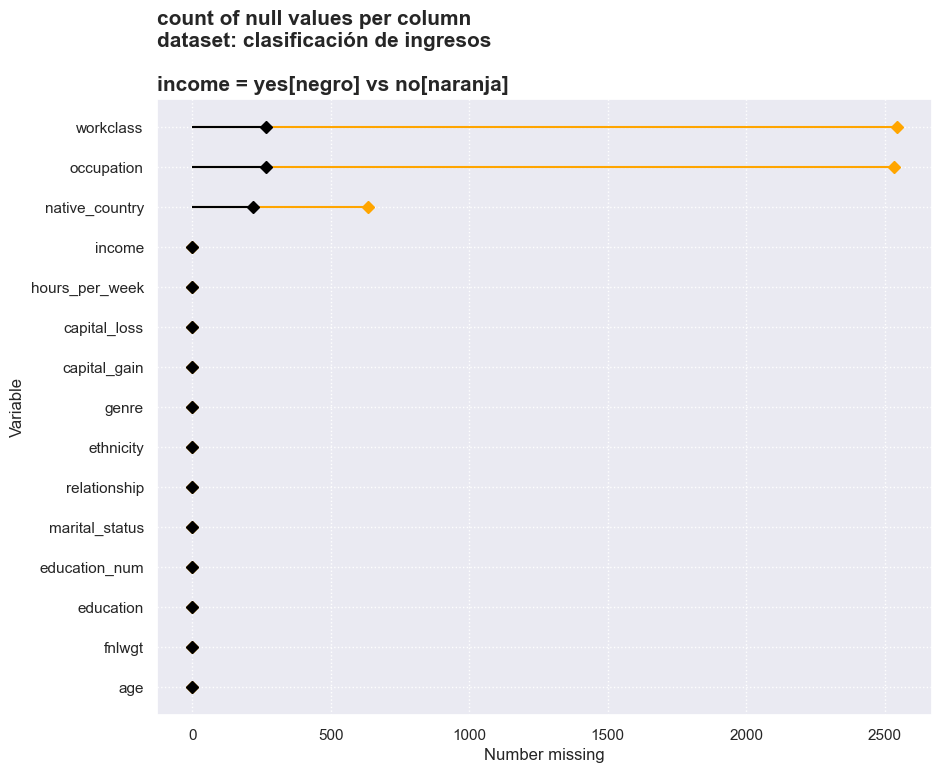

In [14]:
plot_2 = income_no.missing_plot.missing_variable_plot(color= 'orange')
plot_1 = income_yes.missing_plot.missing_variable_plot(
         df_name= 'clasificación de ingresos\n\nincome = yes[negro] vs no[naranja]')
plt.show()

#### Observaciones
* **(1)** En ambos casos la proporción de nulos es menor al $2$%. Un valor relativamente bajo y sugiere que el impacto de los datos faltantes podría ser **mínimo**.
    * siendo más específicos: hay $6464$ nulos de un total de $732195$ 
        * *(conteo total de valores en todo el dataset, no filas)*

* **(2)** Existe una **diferencia** significativa en la proporción de nulos entre *yes* y *no*.
    * `no` tiene más del doble de nulos que `yes` ($1.026$% vs $0.428$%)

<div class="alert alert-warning">
    <b style="font-size: 1.5em;">⚠️ Potenciales problemas ⚠️ </b>
    <p>La diferencia entre las proporciones de nulos de <i>yes</i> vs <i>no</i> podría introducir sesgo en el modelo si los datos faltantes no están distribuidos aleatoriamente <i>(se corroborará a continuación)</i></p>
    <p> Si las filas "<b>income = no</b>" tienen más probabilidades de tener nulos, al eliminar esas filas se <b>reduciría la representatividad de esa clase, y afectar el desempeño del modelo</b>.</p>
<ul>
<li> <i>Aunque la proporción de nulos sea baja. Sería importante considerar si estos datos están relacionados con la variable objetivo</i></li>
</ul>
  
</div>
<div class="alert alert-info">
    <b style="font-size: 1.5em;"> 📘 Eliminación vs imputación</b>
    <ul>
        <li>Si <b>eliminamos</b> los nulos, estaríamos garantizando que solo se usen datos completos y fiables en el análisis y creación del modelo. Pero podría perderse datos importantes. También, podría agregarse un sesgo considerable si la distribución de nulos no es uniforme. O si los nulos no son <b>MCAR/MAR</b></li>
        <br>
        <li>Si <b>imputamos</b> el tamaño original del dataset se mantiene y se preserva toda la información; en adición, se reduce el riesgo de sesgo por eliminación. Pero es necesario seleccionar una metodología de imputación  adecuada, lo que podría ser complejo si los nulos no son <b>MCAR</b>/<b>MAR</b>. Si se comenten errores al imputar, podríamos introducir sesgo al entrenamiento del modelo.</li>
    </ul>
</div>

Argumentos a favor de **eliminación**:
* **(1)** El porcentaje de nulos es considerablemente bajo($7.5$%), por lo que si es que aparecen sesgos, estos podrían afectar muy poco a los resultados
* **(2)** El modelo que se usará para el entrenamiento es sólido y poco suceptible a los sesgos.

Argumentos en contra: 
* La diferencia entre los valores nulos entre `Income` = yes vs no **ES** significativamente grande y plantea la hipótesis de tener valores nulos altamente correlacionados.
* De ser así, la eliminación deberá descartarse


## (1.4) distribución de nulos en el dataset
Para corroborar que no hayan agrupamientos de estos valores

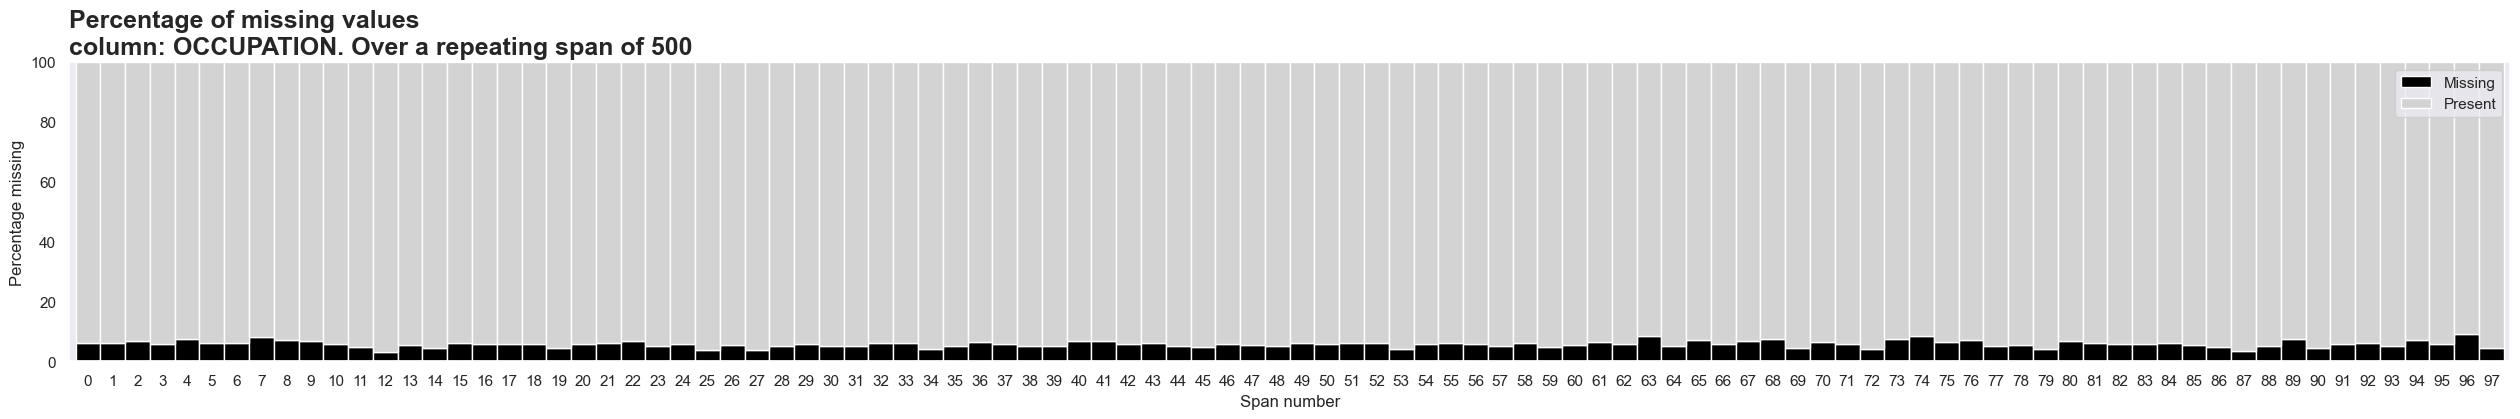

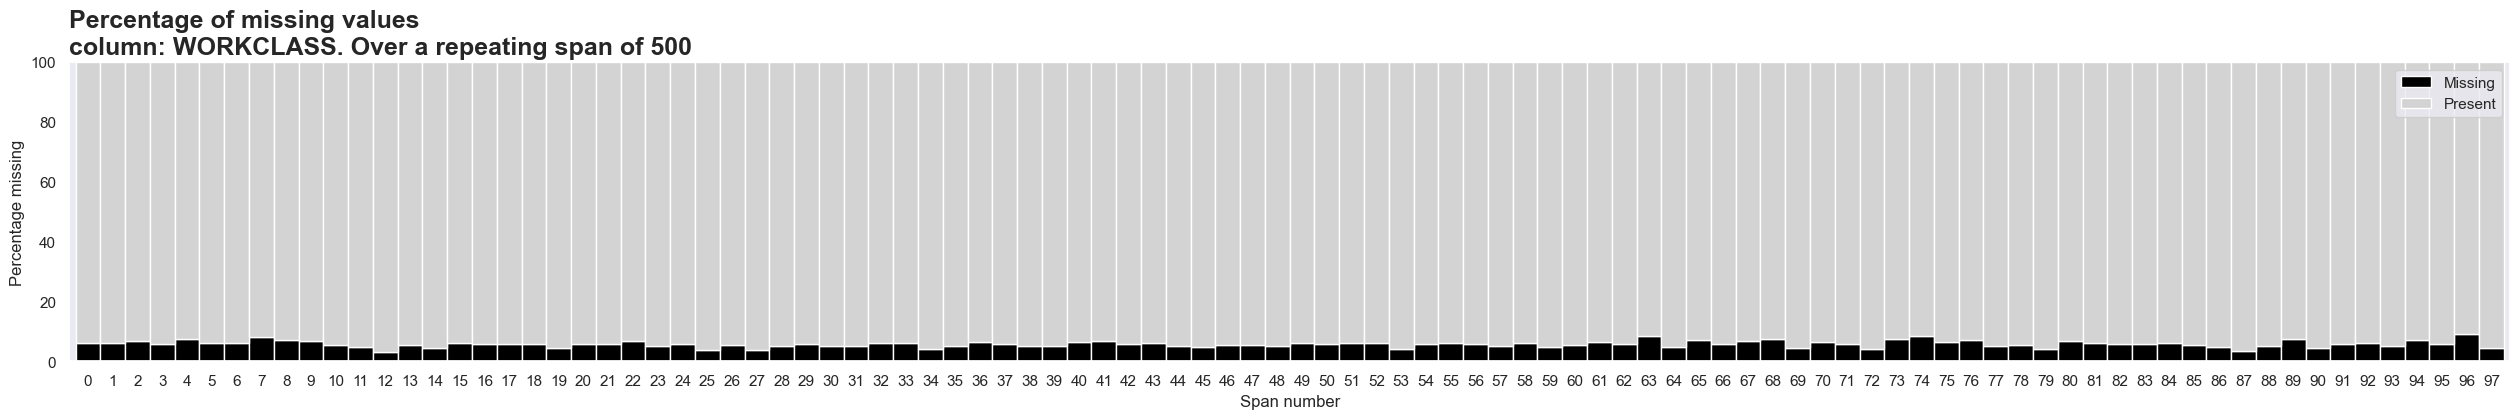

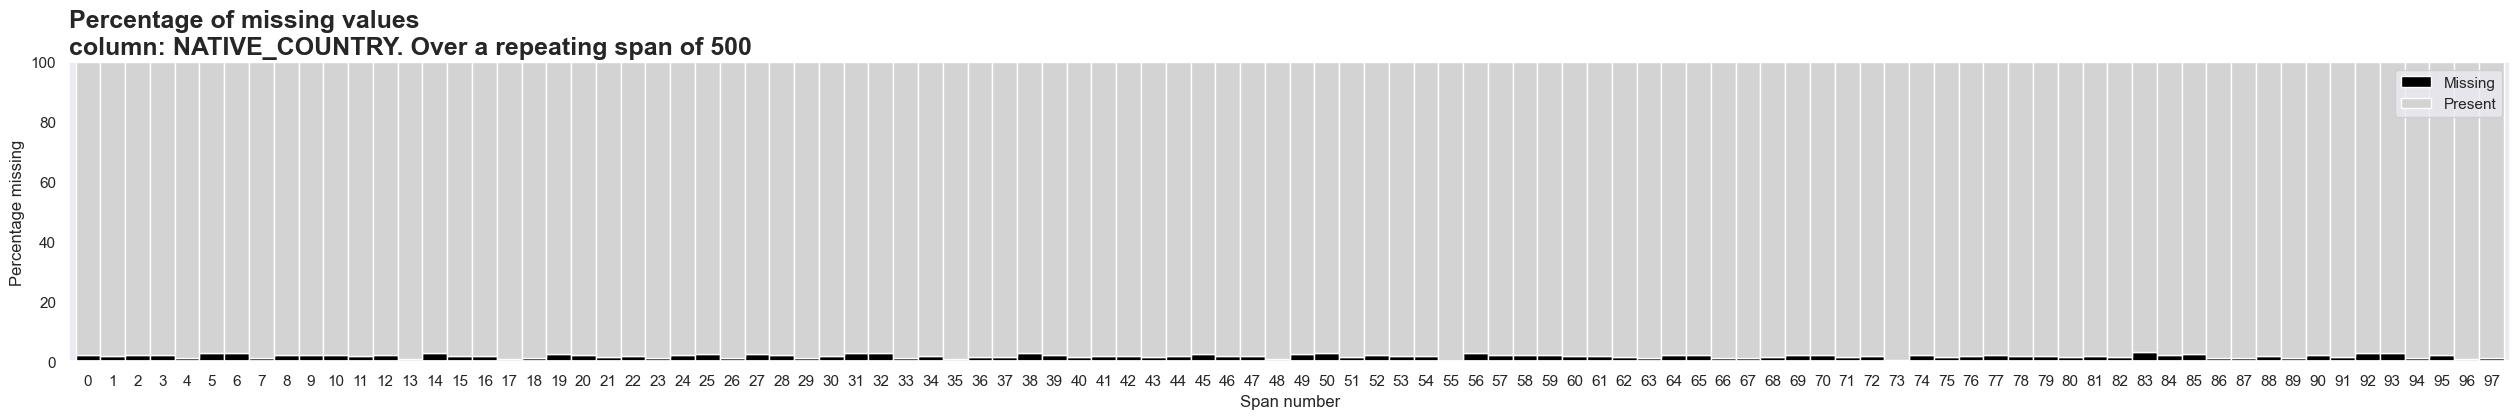

In [15]:
def print_missing_var_span_plot(df: pd.DataFrame):
    list_cols = ['occupation', 'workclass', 'native_country']
    for i in list_cols:
        df.missing_plot.missing_variable_span_plot(column= i, span_every= 500, figsize= (25,4))
        
print_missing_var_span_plot(df_nan)

En las tres gráficas, los nulos *(negro)* aparecen en proporciones muy bajas, confirmando que el porcentajr total de nulos es pequeño (~$7.5$%)
* No se observan agrupaciones significativas o patrones visibles de acumulación de nulos en regiones del dataset. Esto respalda la hipótesis de que los nulos podrían ser MCAR / MAR. O sea que los nulos no estarían relacionados con las demás variables  ni con la variable objetivo *income*

Al no encontrar patrones significativos en la distribución de nulos, es razonable asumir que los datos faltantes no afactarían de forma significativa el balance de las variables al ser eliminados. Esto favorece a la decisión de eliminar los valores faltantes en lugar de imputarlos. dado que: 
* la proporción es baja
* están uniformemente distribuidos en todo el dataset

### Aparición conjunta de nulos

white: rows with nulls, black: complete


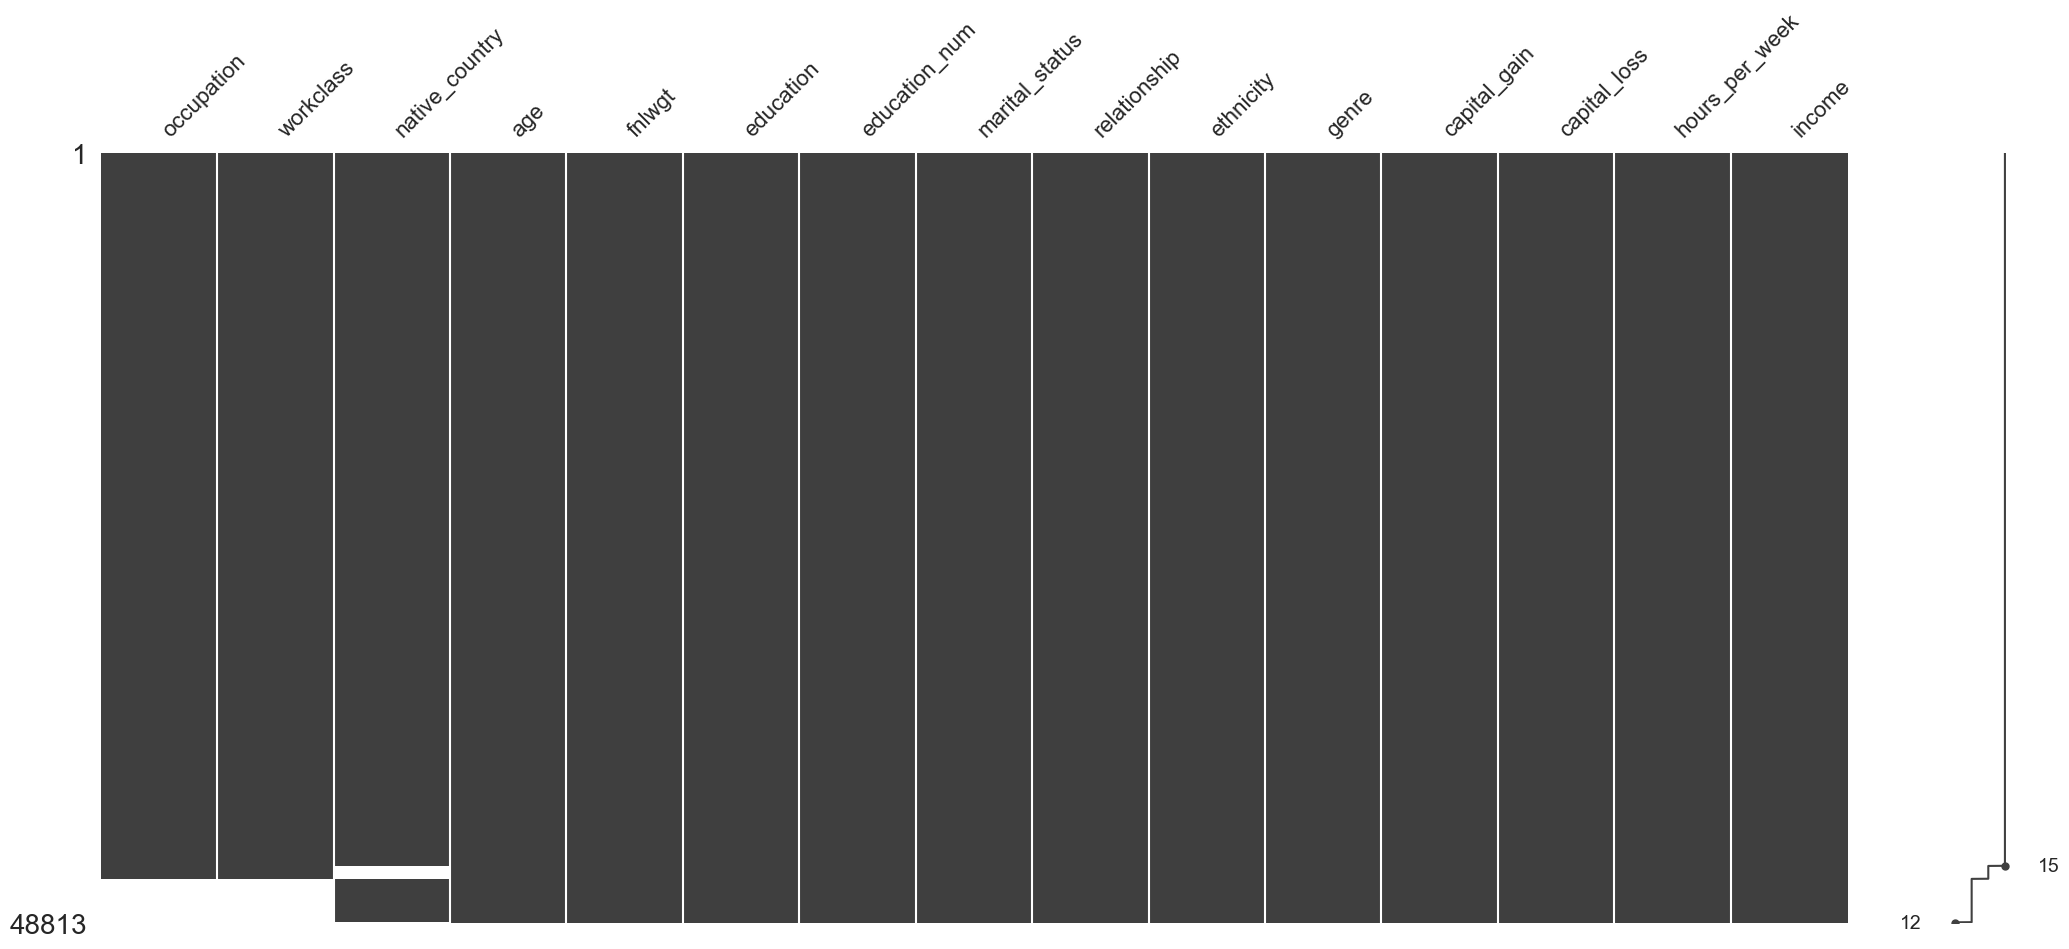

In [16]:
(df_nan.missing.sort_variables_by_missingness()
 .pipe(missingno.matrix, sort= 'descending'))
print('white: rows with nulls, black: complete')

En la parte inferior derecha (eje $y$), se observa un pequeño grupo de nulos concentrados en las mismas columnas. Esto confirma que hay ciertas filas con patrones de nulos específicos. 

* *occupation & workclass* tienen nulos altamente correlacionados. Esto que **refuerza** la necesidad de tratarlos de manera conjunta si se decide imputar.


joint occurrence of nulls. Given income = YES


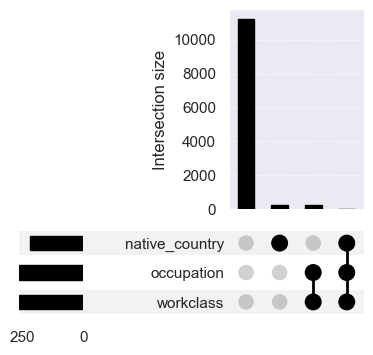

In [17]:
income_yes.missing_plot.missing_upsetplot(cols= ['workclass', 'occupation', 'native_country'])
print('joint occurrence of nulls. Given income = YES')

joint occurrence of nulls. Given income = NO


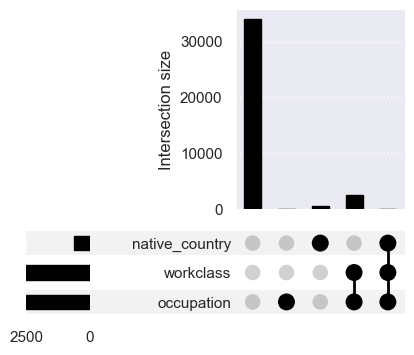

In [18]:
income_no.missing_plot.missing_upsetplot(cols= ['workclass', 'occupation', 'native_country'])
print('joint occurrence of nulls. Given income = NO')

**Observaciones**: 
Al analizar los nulos presentes en filas cuyo income es `yes` vs `no` *(categoría de ingresos anuales)* encontramos una diferencia *relativamente* significativa
* *$H_1$*:Esto sugiere una posible relación entre la presencia de nulos y la categoría de ingresos del sujeto. La mayor proporción de nulos en `income= no` podría indicar que ciertos factores asociados a un menor ingreso **influye** en la completitud de los resultados

    * si se eliminan estas filas con nulos, sin considerar esta asociación, se podría podríamos subrepresentar a `income = no`, afectando la predicción

Para confirmar tal hipótesis, se continuará con un test de $\text{chi}^2$

In [19]:
#1º tabla de contingencia
contingency_table = pd.crosstab(df_nan.isnull().any(axis=1), df_nan['income'])

#test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-squared: {chi2}\nP-value:     {p}')# pffff 

Chi-squared: 245.26760991896288
P-value:     2.7937154697982916e-55


**P value**: Es extremadamente bajo $2.79 * 10^{-55}$, mucho menor que cualquier nivel de significancia comúnmente utilizado ($.05, .01, .001$)
* Se **rechaza** la hipóteis nula ($H_0$) sobre la independencia entre los nulos y la variable objetivo `income`.

**Conclusiones del cálculo:**
* Existe una asociación estadísitamente significativa entre las variables con nulos y la objetivo
* Existe una ocurrencia **no aleatoria** entre los niveles de ingreso y los nulos
* La mayor incidencia de nulos en sujetos con $<=50$ k están influyendo en la completitud de los valores

<div class="alert alert-info">
    <b style="font-size: 1.5em;"> 💭 Entonces, ¿Eliminamos?</b>
    <p>Las gráficas confirman que hay más nulos en <i>income = no</i> (<b>1.026%</b>) en comparación con <i>yes</i> (<b>0.428%</b>).</p>
    <ul>
        <li> Esto sugiere que la eliminación de nulos afectaría más a la clase<code>income = no</code>. <b>Podría introducir un sesgo en el dataset</b> si no se maneja correctamente.</li></ul>
    <ul>
        <li>Aunque la proporción de nulos es baja (<b>~7.5%</b>), el patrón de aparición conjunta entre <code>occupation</code> y <code>workclass</code> es significativo. <i> La imputación de estas columnas será la mejor opción para mantener la integridad del dataset</i>.</li>
    </ul>
    <p>Dada esta situación, <b>eliminar los nulos afectaría negativamente</b> al futuro entrenamiento del modelo.</p>
    <ul>
        <li>Las ocurrencias de nulos en <code>income = yes</code> y <i>native_country</i> están menos relacionados con estas columnas.</li>
        <li>Se observa un <b>patrón de aparición conjunta</b> entre "<i>occupation & workclass</i>", lo que sugiere que estos nulos están relaciónados y podrían no ser completamente aleatorios</li>
        <br>
        <li>Las ocurrencias en <code>income = no</code> tienen un comportamiento similar que pero en mayor cantidad.</li>
    </ul>
    <br>
    <b style="font-size: 1.5em;"> Conclusión</b>
    <p>Los nulos <b>no</b> son completamente aleatorios (<i><del>MCAR</del></i>) y están concentrados en <i>no</i> y <b>se deberá imputar</b></p> 
</div> 


## (1.5) imputación
Se ha decidido implementar dos estrategias de imputación y luego comparar su desempeño.
* imputación por moda *(tomamos el valor más común y reemplazamos el nulo por esta categoría)*
* imputación por árboles de desición

Dado que se ha observado una diferencia significativa en el comportamiento de nulos entre la predictora (`income= `yes/no). Será prudente hacer una imputación estratificando el dataset.
* Es decir, de dividirá el dataset por filas donde income = **yes**, y **no**
* La metodología se repetirá en ambos casos

### imputación por moda

Dado que las columans problemáticas son categóricas. Es razonable pensar en una imputación por moda, la implementación de esta metodología se refuerza por el bajo porcentaje de nulos en el dataset.

Aquí separamos el DataFrame en dos subconjuntos: uno con income = yes y otro con income = no.

In [20]:
df_subset_mode = df_nan.copy()

# se imputará respetando la distribución interna de cada clase
# para luego hacer imputación por moda en cada subset
df_yes_mode = df_subset_mode[df_subset_mode['income'] == 'yes'].copy() 
df_no_mode  = df_subset_mode[df_subset_mode['income'] == 'no' ].copy() 

cols_to_impute = ['workclass', 'occupation', 'native_country']

df_yes_mode = imputation.impute_mode(df_yes_mode, cols_to_impute) #--------------- Imputamos subsets por separado
df_no_mode  = imputation.impute_mode(df_no_mode,  cols_to_impute)

df_imputed_mode = pd.concat([df_yes_mode, df_no_mode], axis=0) #------- fusionamos de nuevo los subsets en un único DF
df_imputed_mode = df_imputed_mode.sort_index() #------------- orden original


In [21]:
df_imputed_mode[cols_to_impute].isnull().sum() # sin nulos 🎉🎉

workclass         0
occupation        0
native_country    0
dtype: int64

In [22]:
labels = ['workclass', 'occupation', 'native_country']
labels[0]

'workclass'

In [23]:
df_imputed_mode['occupation'].value_counts()

occupation
adm_clerical         8152
exec_managerial      6349
prof_specialty       6167
craft_repair         6107
sales                5504
other_service        4919
machine_op_inspct    3019
transport_moving     2355
handlers_cleaners    2071
farming_fishing      1487
tech_support         1445
protective_serv       983
priv_house_serv       240
armed_forces           15
Name: count, dtype: int64

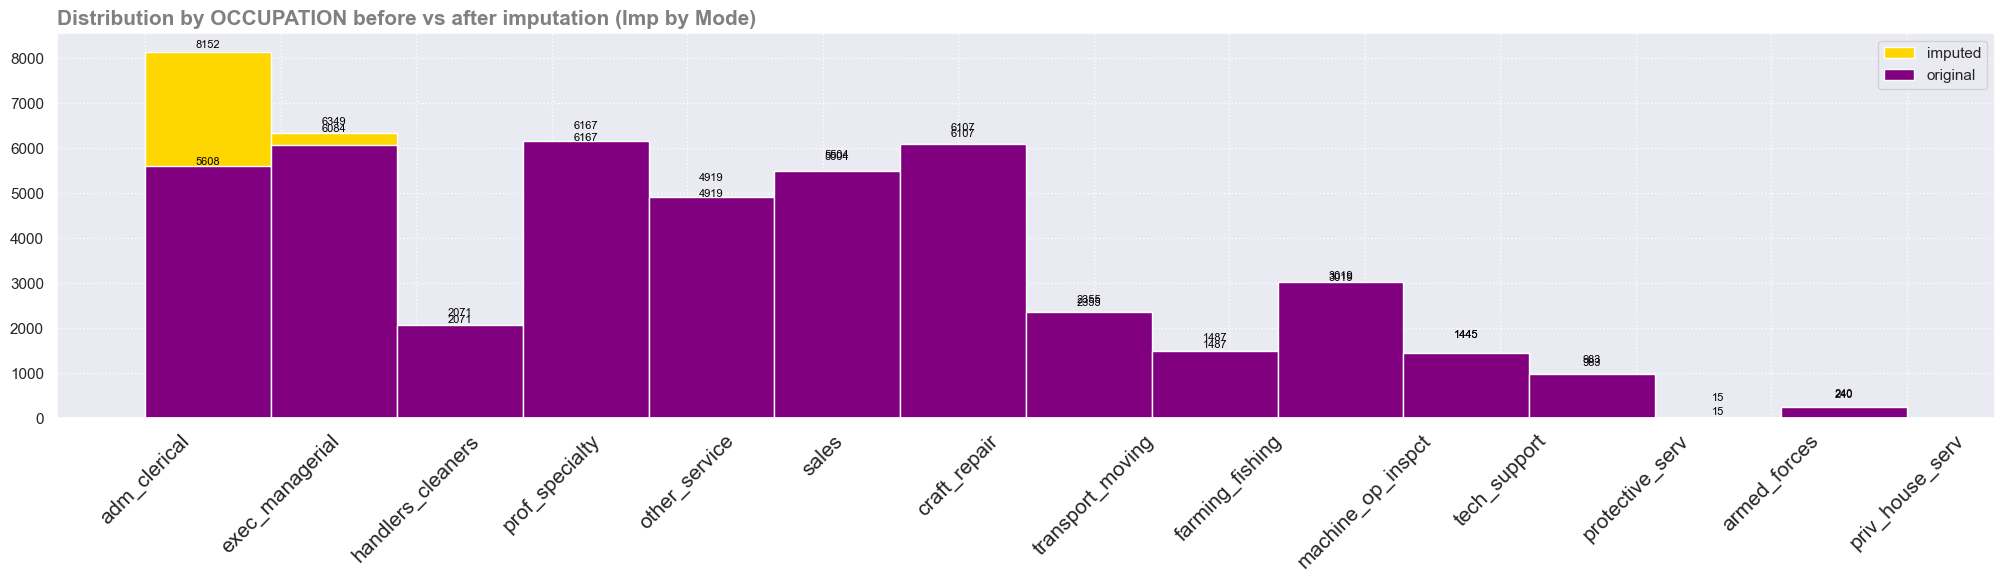

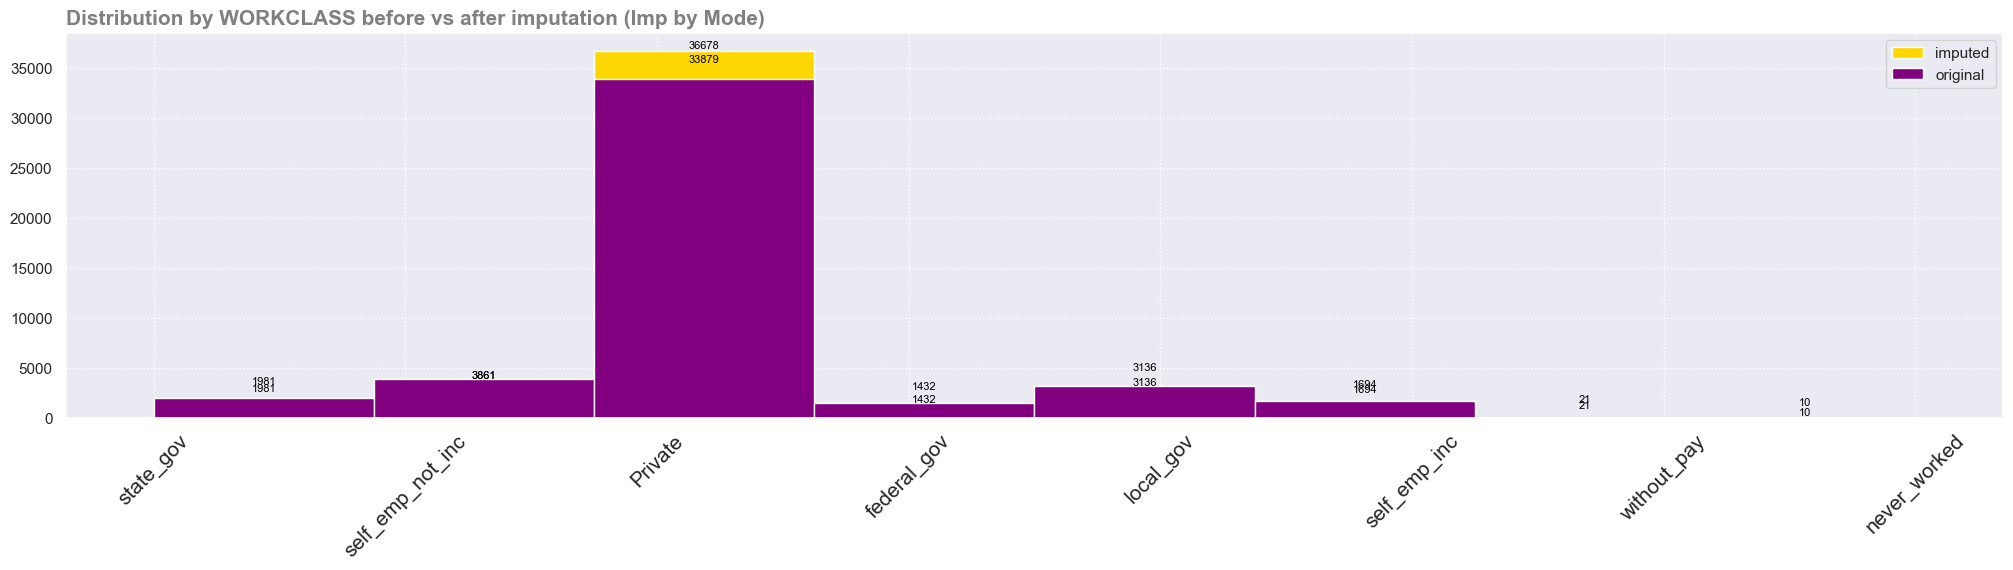

In [24]:
#comparación: distribución entre variables categóricas antes y después de la imputación
for col, bin_val in zip(['occupation', 'workclass'], [14, 8]):
    
    imputation.before_vs_after_imputed(df_original=df_nan, df_imputed=df_imputed_mode,
                                       col= col, imp_strategy= 'mode', bins= bin_val)

### imputación por árboles de desición
no tiene sentido que `native_country` se impute por árboles de desición, porque:
* no es una variable que muestre estar correlacionada con `income` o con las demás variables afectadas

por este motivo se hará por la moda

In [25]:
# comenzamos con la impuación por la moda para native_country
df_subset_tree = df_nan.copy()

#estratificamos (target -> income)
df_yes_tree = df_subset_tree[df_subset_tree['income'] == 'yes'].copy()
df_no_tree  = df_subset_tree[df_subset_tree['income'] == 'no'].copy()

# imputación 1: native_country por la moda (en cada subset)
df_yes_tree = imputation.impute_mode(df_yes_tree, ['native_country']) # func path: ./modules/module_imputation.py
df_no_tree  = imputation.impute_mode(df_no_tree,  ['native_country'])

# Recombinamos tras la imputación
df_imputed_tree = pd.concat([df_yes_tree, df_no_tree], axis=0)
df_imputed_tree.columns
df_imputed_tree = df_imputed_tree.sort_index() # orden original

### 
<div class="alert alert-info">
    <b style="font-size: 1.5em;">🤺 Estrategia y lógica de imputación:</b>
    <ol>
        <li><b>ESTRATIFICAMOS</b> por la variable objetivo <i>para hacer la imputación independiente para cada subset.</i></li>
        <li>Haremos dos <b>df's temporales</b> para detectar <i>valores nulos y conocidos</i>: <code>df_known, df_unknown</code>.</li>
        <li>Para cada df's (valores conocidos y desonocidos) se implemetará un <b>enconding</b> para aplicarlo al entrenamiento del modelo
        <li>Entrenaremos un modelo de árboles de desición para predecir <code>occupation</code> <i>(sólo con las filas que tienen 'occupation' no nulo)</i>
            <p><i>revisar func -></i> <code>impute_with_model</code> path: '<i>./modules/module_imputation.py</i>'</p>
        </li>
        <li>Aplicaremos el modelo a las filas con un <code>occupation</code> nulo.</li>
            <p>repetir métodología en <code>workclass</code></p>
        <li>Pasaremos los resultados de los df's temporales a los estratificados originales. Para fusionar ambos df's, obteniendo el mismo dataset, pero esta vez con los nulos imputados.</li>
    </ol>

In [26]:
# estratificamos (target -> income)
df_yes_tree = df_imputed_tree[df_imputed_tree['income'] == 'yes'].copy()
df_no_tree  = df_imputed_tree[df_imputed_tree['income'] == 'no' ].copy()

# OCCUPATION es la variable objetivo -> 
# NOTE: excluimos 'income' y 'occupation', 'workclass'(<- porque tiene nulos)
exclude_cols = ['income', 'workclass']

df_yes_tree = imputation.impute_with_model(df= df_yes_tree,
                                           target_col= 'occupation',
                                           predictors_to_exclude= exclude_cols)

df_no_tree  = imputation.impute_with_model(df= df_no_tree,
                                           target_col= 'occupation',
                                           predictors_to_exclude= exclude_cols)

df_imputed_tree = pd.concat([df_yes_tree, df_no_tree], axis=0).sort_index()

df_yes_tree = df_imputed_tree[df_imputed_tree['income'] == 'yes'].copy()
df_no_tree  = df_imputed_tree[df_imputed_tree['income'] == 'no' ].copy()

# WORKCLASS -> excluimos la var objetivo
# NOTE: 'workclass' es la variable objetivo y 'occupation' ya ha sido imputada
# (por eso no se coloca en la lista)
df_yes_tree = imputation.impute_with_model(df= df_yes_tree,
                                           target_col= 'workclass',
                                           predictors_to_exclude=['income'])

df_no_tree  = imputation.impute_with_model(df= df_no_tree,
                                           target_col= 'workclass',
                                           predictors_to_exclude=['income'])

df_imputed_tree = pd.concat([df_yes_tree, df_no_tree], axis=0).sort_index()
#-#-#–#–#–#

df_imputed_tree.columns
df_imputed_tree[['workclass', 'occupation', 'native_country']].isnull().sum()

workclass         0
occupation        0
native_country    0
dtype: int64

In [27]:
count_original_data = df_subset_tree.isnull().sum().sum()
count_imputed_data  = df_imputed_tree.isnull().sum().sum()
print(f'Conteo total de nulos (tree):\n original: {count_original_data}\n imputed:  {count_imputed_data}')

Conteo total de nulos (tree):
 original: 6464
 imputed:  0


In [28]:
df_imputed_tree # sin fucking nulos!!!!!!sdñ fighadñfilgjqaeroñl

,occupation,workclass,native_country,age,fnlwgt,education,education_num,marital_status,relationship,ethnicity,genre,capital_gain,capital_loss,hours_per_week,income
0,adm_clerical,state_gov,USA,39,77516,bachelors,13,never_married,not_in_family,white,Male,2174,0,40,no
1,exec_managerial,self_emp_not_inc,USA,50,83311,bachelors,13,married_civ_spouse,husband,white,Male,0,0,13,no
2,handlers_cleaners,Private,USA,38,215646,hs_grad,9,divorced,not_in_family,white,Male,0,0,40,no
3,handlers_cleaners,Private,USA,53,234721,11th,7,married_civ_spouse,husband,black,Male,0,0,40,no
4,prof_specialty,Private,Cuba,28,338409,bachelors,13,married_civ_spouse,wife,black,Female,0,0,40,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48808,prof_specialty,Private,USA,39,215419,bachelors,13,divorced,not_in_family,white,Female,0,0,36,no
48809,craft_repair,Private,USA,64,321403,hs_grad,9,widowed,other_relative,black,Male,0,0,40,no
48810,prof_specialty,Private,USA,38,374983,bachelors,13,married_civ_spouse,husband,white,Male,0,0,50,no
48811,adm_clerical,Private,USA,44,83891,bachelors,13,divorced,own_child,asian_pac_islander,Male,5455,0,40,no


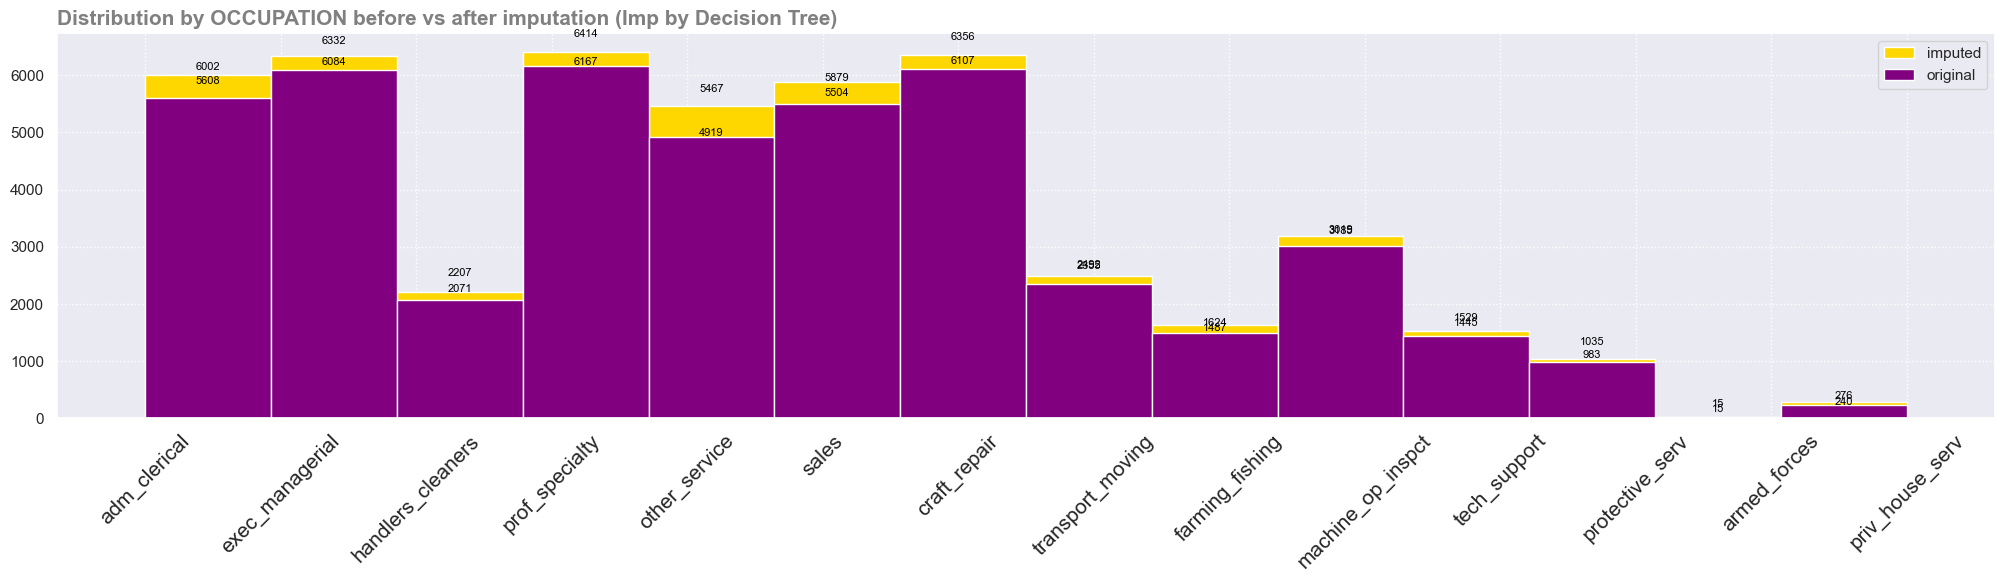

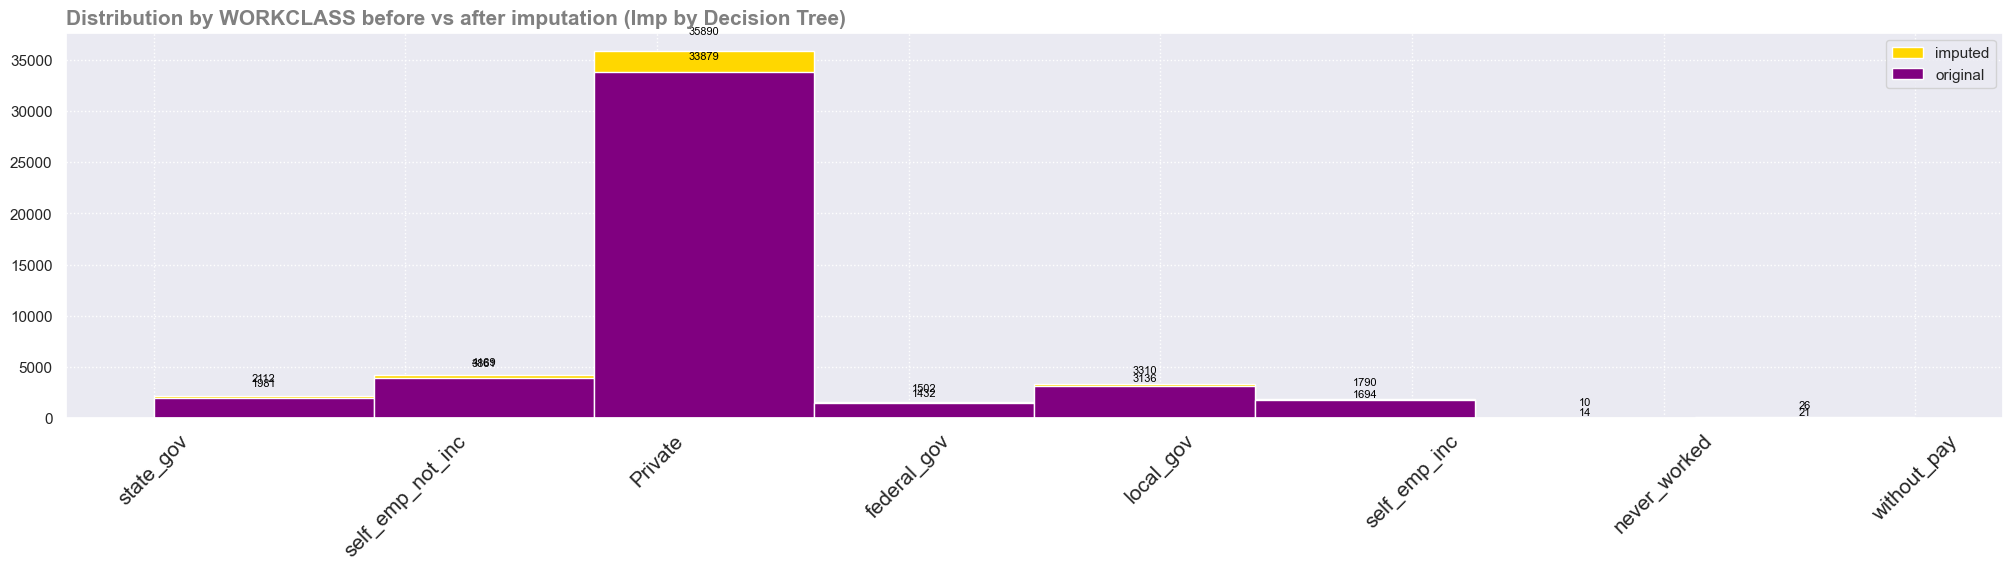

In [29]:
for col, bins_val in zip(['occupation', 'workclass'], [14,8]):
    imputation.before_vs_after_imputed(df_original= df_subset_tree,
                                       df_imputed=  df_imputed_tree,
                                       col= col,
                                       imp_strategy= 'tree',
                                       bins= bins_val)

#### imputación: **moda** vs **decision trees**

In [30]:
#comparación entre ambas imputaciones: moda vs árbol
mode_imp_mode = df_imputed_mode['workclass'].value_counts()
tree_imp_mode = df_imputed_tree['workclass'].value_counts()

df_mode_imputation = pd.concat([mode_imp_mode, tree_imp_mode], axis= 1, keys= ['mode', 'tree'])

mode_imp_occ = df_imputed_mode['occupation'].value_counts()
tree_imp_occ = df_imputed_tree['occupation'].value_counts()

df_tree_imputation = pd.concat([mode_imp_occ, tree_imp_occ], axis= 1, keys= ['mode', 'tree'])
df_mode_imputation

,mode,tree
workclass,,
Private,36678,35890
self_emp_not_inc,3861,4169
local_gov,3136,3310
state_gov,1981,2112
self_emp_inc,1694,1790
federal_gov,1432,1502
without_pay,21,26
never_worked,10,14


In [31]:
df_tree_imputation

,mode,tree
occupation,,
adm_clerical,8152,6002
exec_managerial,6349,6332
prof_specialty,6167,6414
craft_repair,6107,6356
sales,5504,5879
other_service,4919,5467
machine_op_inspct,3019,3185
transport_moving,2355,2492
handlers_cleaners,2071,2207


comparando ambos resultados

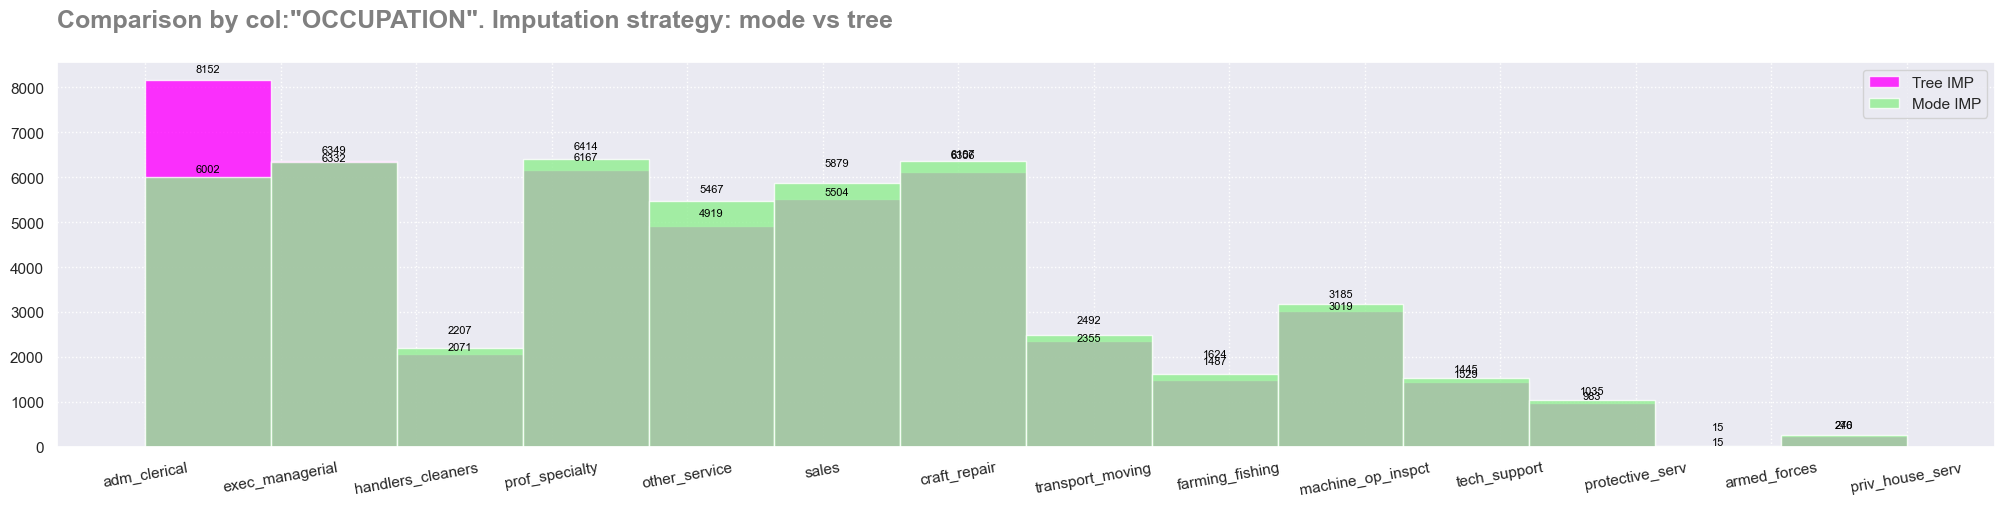

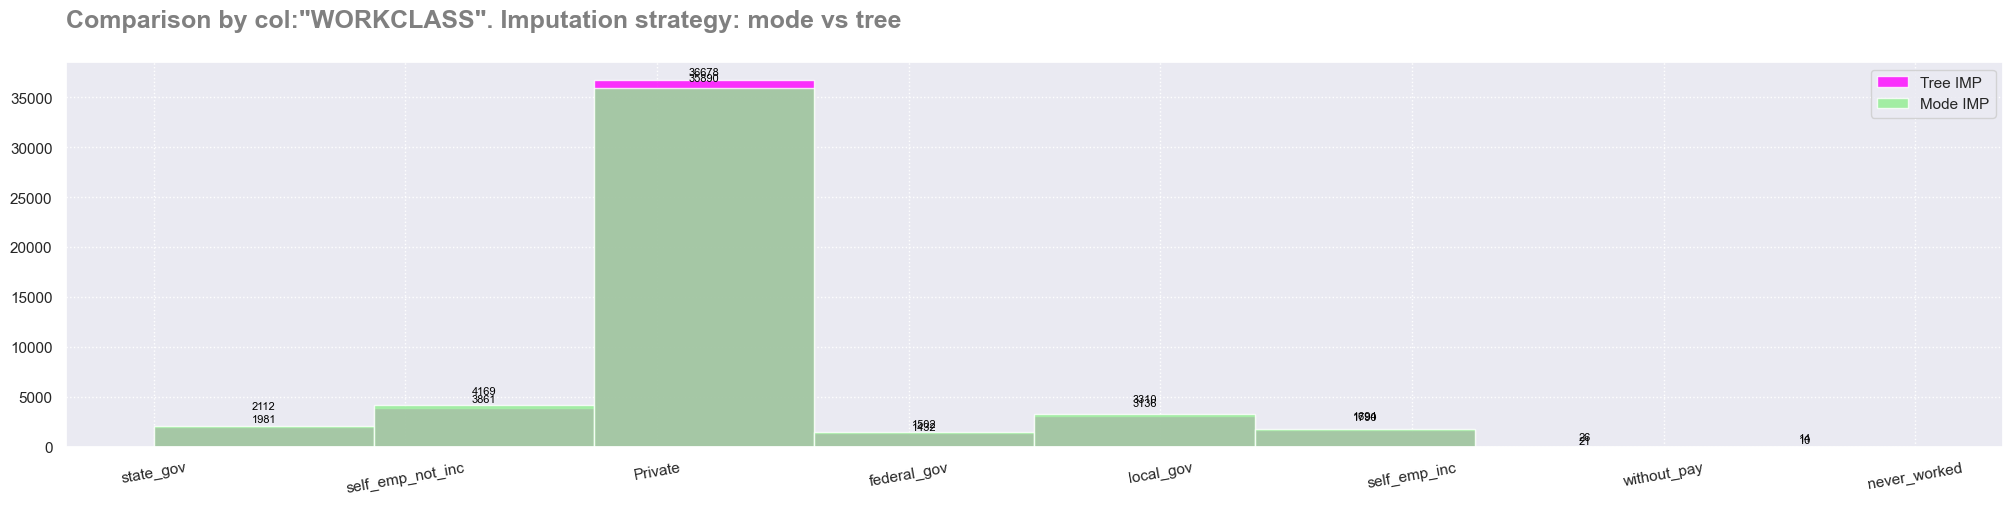

In [32]:
for col, bin_val in zip(['occupation', 'workclass'], [14, 8]):
    imputation.compare_col_dfs(df_1= df_imputed_mode, df_2= df_imputed_tree,
                               col= col, rotation= 10, bins= bin_val, 
                               colors= ['magenta', 'lightgreen'], labels= ['Tree IMP', 'Mode IMP'],
                               title= 'Imputation strategy: mode vs tree\n')

#### observaciones
La imputación por desicion trees distribuye los nulos de manera más uniforme entre las categorías. A comparación de la imputación por la moda que se centra en imputar por el valor más común. 
* En este caso específico el sesgo que estaría añadiendo la imputación por la moda es poco significativo y con poco impacto a los valores completos (dada la poca cantidad de nulos, equivalente al $7.5$% del total de valores).
    * Sin embargo, la imputación por árboles de desición resulta más  adecuada porque utiliza relaciones entre variables para realizar la imputación.

imputación elegida: **desicion tree** *(ligeramente mejor)*


In [33]:
df_final = df_imputed_tree.copy()
#load.save_dataframe(df= df_final, file_name= 'adult_imputed', dir= 'clean')

#### estadísticas de resultados

In [34]:
#df_final.info()

In [35]:
df_final.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,48813.000000,4.881300e+04,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,1.896679e+05,10.078688,1079.708705,87.554299,40.425051
std,13.709005,1.056062e+05,2.570257,7454.185982,403.118605,12.390954
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781400e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


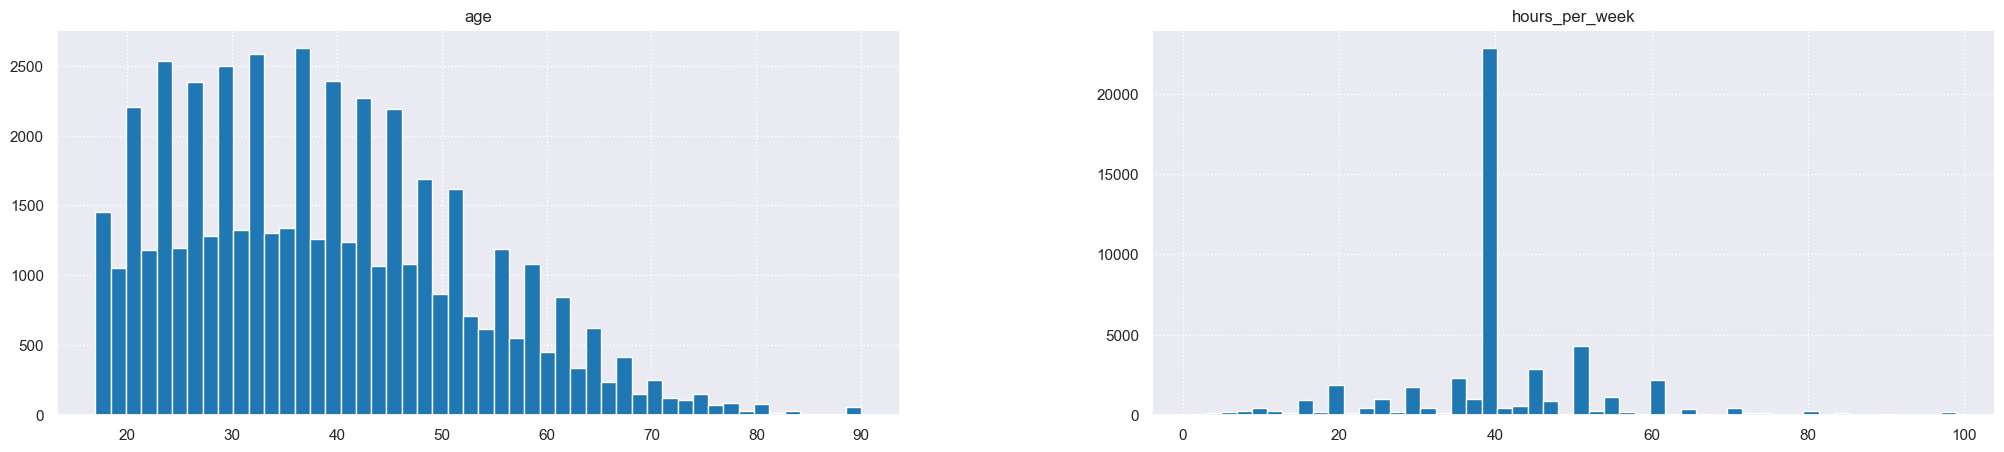

In [36]:
df_final.hist(column= ['age','hours_per_week'], bins= 50, figsize= (25, 5))
plt.show()

In [37]:
# (df_final['occupation']
#  .value_counts()
#  .plot(kind='bar', figsize= (15, 5), color= 'lightblue'))
# plt.show()

# (df_final['workclass']
#  .value_counts()
#  .plot(kind='bar', figsize= (15, 5), color= 'lightgreen'))
# plt.show()

In [38]:
# relación entre las categóricas imputadas
pd.crosstab(df_final['occupation'], df_final['income'], normalize= 'index') *100

income,no,yes
occupation,,
adm_clerical,86.771076,13.228924
armed_forces,66.666667,33.333333
craft_repair,77.894902,22.105098
exec_managerial,52.969046,47.030954
farming_fishing,88.669951,11.330049
handlers_cleaners,93.701858,6.298142
machine_op_inspct,88.194662,11.805338
other_service,96.103896,3.896104
priv_house_serv,98.550725,1.449275


**yes (ingresos altos)**:

* `prof_speciality`: ($44.04$%)
* `exec_managerial`: ($47.04$ %)

destacan con la proporción de ingresos más altos. Tiene sentido ya que estas ocupaciones tienden a estar asociadas con trabajos con mayor nivel de ingresos

**no (ingresos bajos)**:

* `priv_house_ser`: ($98.5$%)
* `other_service`: ($96.10$ %)
* `handlers_cleaners`: ($93.70$ %)

Tienen un gran porcentaje de apariciones en ingresos bajos. (total de apariciones en yes o en no). Tienden a estar asociadas con trabajos de baja remuneración y menos requisitos de estudios / habilidades

<div class="alert alert-success">
    <b style="font-size: 1.5em;">conclusión</b>
    <p>Existe una relación clara entre la ocupación y el nivel de ingresos. <code>income</code></p>
    <ul>
        <li>Ocupaciones con alta especialización tienden a correlacionarse con ingresos <b>altos</b></li>
        <li>Mientras que trabajos menos requerimientos tienden a relacionarse con ingresos <b>bajos</b></li>
    </ul>
    
</div> 

## (1.6) búsqueda de correlación *(lineal)*

In [39]:
pd.crosstab(df_final['workclass'], df_final['income'], normalize= 'index') *100

income,no,yes
workclass,,
Private,79.010867,20.989133
federal_gov,61.984021,38.015979
local_gov,71.540785,28.459215
never_worked,100.000000,0.000000
self_emp_inc,45.865922,54.134078
self_emp_not_inc,73.111058,26.888942
state_gov,74.100379,25.899621
without_pay,92.307692,7.692308


Workclass también está correlacionado con el nivel de ingresos. *Aunque con menos fuerza, dada la estratificación de algunas categorías.*
* los trabajos en sectores gubernamentales ($38.01$% = yes) y autónomos ($54.13$% = yes) tienen mejores oportunidades de ingresos altos que aquellos en sectores privados o sin empleo
    * esto tiene sentido, ya que los trabajadoes independientes (**sel_emp_inc**) suelen tener ingresos más altos. aunque en todas las categorías de estavariable tiende a tener un comportamiento más estratificado

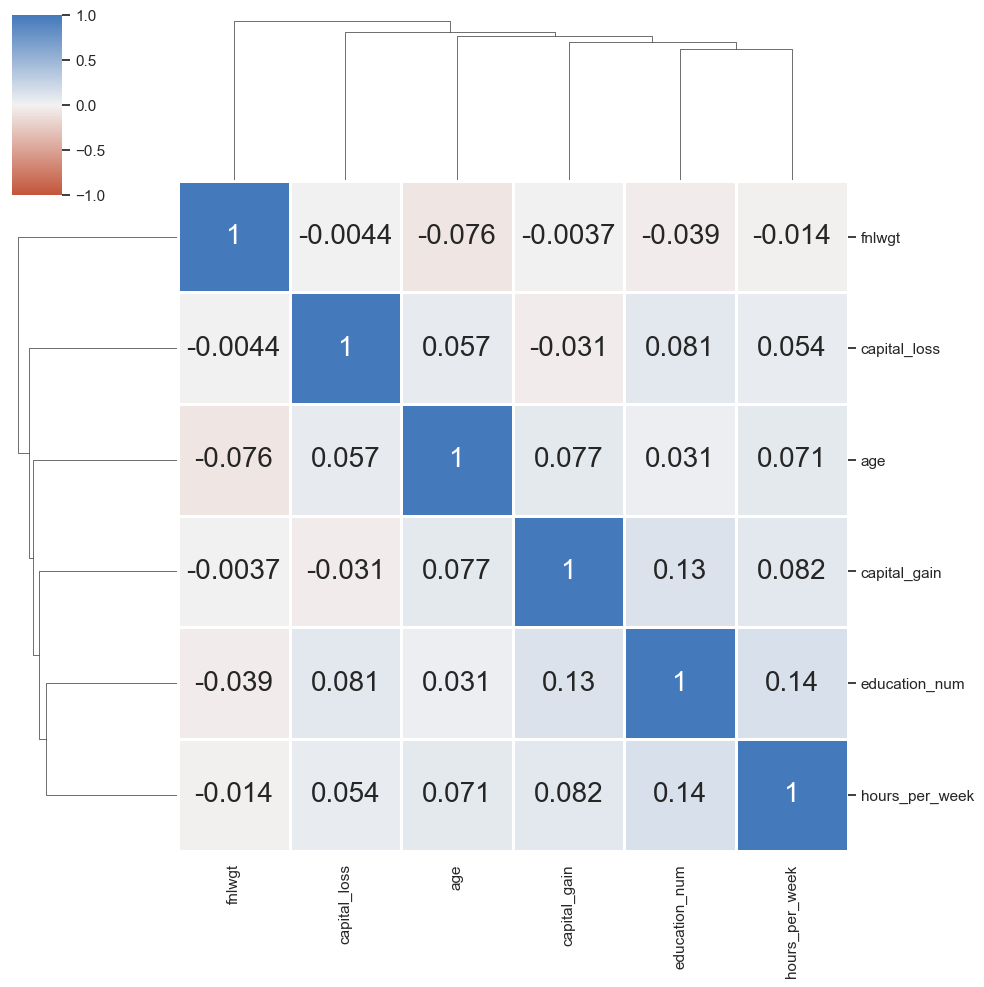

In [40]:
# clustermap
num_cols_corr = df_final.select_dtypes(include= ['int', 'float']).columns
initial_exp.correlation_plot(df= df_final, columns= num_cols_corr, annot_size= 20)

<div class="alert alert-success">
    <b style="font-size: 1.2em;">correlación positiva (débil):</b>
    <p><code>education_num</code> & <code>capital_gain</code> (<b>0.125</b>):</p>
    <ul>
        <li>Las personas con mayor nivel educativo tienden a generar mayores ganancias. Lo cual es razonable, ya que suelen estar en mejores posiciones financieras</li>
    </ul>
    <b style="font-size: 1.2em;">correlación débil:</b>
    <p>En general, las correlaciones entre variables numéricas son bastante débiles (0.15)</p>
    <ul>
        <li>Esto indica que las relaciones entres las variables son débiles y no lineales</li>
        <li>Este tipo de relaciones (no lineales) podrían beneficiarse de la exploración de métodos tales como árboles de desición o redes neuronales</li>
         <li><code>fnlwgt</code>(peso de la muestra). Aparentemente, esta variable no aporta mucha información al análisis predictivo. aunque podría ser por que la relación que existe es más bien no lineal</li>
    <p>Algo a tener en cuenta es que la metodología utilizada <i>(Pearson)</i> analiza si existe una relación lineal entre las variables.<br><br>En el siguiente notebook se indagará si efectivamente, hay poca corralación entra las variables de entrenamiento vs target, o más bien la relación es no lineal</p>
</div> 